In [1]:
import datetime
import os
import random
import readline
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import netCDF4
import numpy
import pandas
import scipy
import seaborn
import xarray as xr
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib import colors, font_manager, pyplot
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from scipy import fft, linalg, stats
from scipy.stats import poisson, ttest_ind
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize
from statsmodels.tsa.ar_model import AutoReg

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_ExTC_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_ExTC_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time = []
    Months = []
    Birth_Time = []
    Start_Time = []
    End_Time = []
    Death_Time = []
    Peak_Time = []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
        Months.append(Month(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Birth_Time.append(Datetime(ET_DF["Genesis Time"][j]))
        Start_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        End_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Death_Time.append(Datetime(ET_DF["Dissipate Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    Data_DF["Month"] = Months
    ET_DF["Genesis Time"] = Birth_Time
    ET_DF["ET Begin Time"] = Start_Time
    ET_DF["ET Complete Time"] = End_Time
    ET_DF["Dissipate Time"] = Death_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
def Month(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
        Month = New_Time.month
    except:
        Month = numpy.nan
    return (Month)

In [7]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)
Lon_Bins = Create_Bins(-100,20,5)
Lat_Bins = Create_Bins(0,60,5)

In [8]:
Num_Years = numpy.array([90,93,93])

In [9]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [10]:
Control_ET

,Code,Name,Trans Type,Genesis Time,ET Begin Time,ET Complete Time,Dissipate Time,Peak Time,Peak SLP,Peak Lon,...,Genesis Lat,ET Begin SLP,ET Begin Lon,ET Begin Lat,ET Complete SLP,ET Complete Lon,ET Complete Lat,Dissipate SLP,Dissipate Lon,Dissipate Lat
0,TC190001,Alex,3,1900-06-19 12:00:00,1900-07-03 18:00:00,1900-07-03 18:00:00,1900-07-04 00:00:00,1900-06-25 06:00:00,987.41,-84.91,...,27.99,1015.57,-90.75,36.25,1015.57,-90.75,36.25,1015.96,-90.75,36.00
1,TC190003,Colin,1,1900-09-09 18:00:00,1900-09-18 00:00:00,1900-09-20 12:00:00,1900-09-20 18:00:00,1900-09-19 12:00:00,934.83,-70.67,...,12.39,952.06,-77.17,31.14,979.68,-62.68,47.61,981.64,-60.41,49.34
2,TC190004,Dawn,1,1900-10-29 00:00:00,1900-11-05 12:00:00,1900-11-06 12:00:00,1900-11-09 06:00:00,1900-11-04 00:00:00,948.88,-91.58,...,19.22,954.74,-87.08,27.00,992.74,-74.44,30.88,1007.87,-24.00,44.75
3,TC190005,Ernest,1,1900-10-31 18:00:00,1900-11-06 00:00:00,1900-11-08 00:00:00,1900-11-08 06:00:00,1900-11-06 18:00:00,988.17,-20.93,...,27.02,996.02,-27.73,41.42,998.22,-9.00,45.00,1001.62,-6.50,44.25
4,TC190102,Harrison,1,1901-05-23 00:00:00,1901-05-28 12:00:00,1901-05-30 18:00:00,1901-06-01 06:00:00,1901-05-27 06:00:00,980.89,-51.83,...,22.04,991.56,-43.71,30.04,1008.78,-34.75,24.00,1019.20,-38.00,21.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,TC198802,Micah,1,1988-02-02 00:00:00,1988-02-06 00:00:00,1988-02-06 06:00:00,1988-02-07 12:00:00,1988-02-05 06:00:00,998.09,-35.19,...,37.07,999.63,-31.01,38.29,999.02,-28.74,38.72,1006.90,-16.25,41.50
323,TC198805,Seldoen,1,1988-08-29 06:00:00,1988-09-07 06:00:00,1988-09-08 12:00:00,1988-09-09 12:00:00,1988-09-07 00:00:00,980.43,-49.24,...,13.12,984.68,-48.37,33.35,987.91,-35.17,42.45,993.00,-15.00,50.50
324,TC198808,Alice,2,1988-09-06 12:00:00,1988-09-12 06:00:00,1988-09-12 12:00:00,1988-09-13 06:00:00,1988-09-13 06:00:00,990.70,-21.25,...,26.09,1009.08,-39.50,44.00,1008.35,-37.50,45.75,990.70,-21.25,51.00
325,TC198809,Bruce,1,1988-09-15 06:00:00,1988-09-21 06:00:00,1988-09-27 00:00:00,1988-09-27 18:00:00,1988-09-22 00:00:00,934.40,-63.31,...,26.61,961.07,-66.39,30.40,1001.36,-41.00,47.00,989.96,-43.00,53.50


In [11]:
# Function For Creating Cumulative Distribution
def Cum_Dist(Array, Ascend):
    Array = Array[Array > -728]
    if Ascend == True:
        Sorted = numpy.sort(Array)
    else:
        Sorted = numpy.sort(Array)[::-1]
    Len = len(Sorted)
    Density = numpy.arange(0,1.0000001,1/(Len-1))
    return (Sorted, Density)

In [12]:
# Create Function to Plot ET Cumulative Distributions
def ET_Cum_Dist_Plot(Fig, ET_DF_1, ET_DF_2, ET_DF_3, Var, Begin, Ascend, Horiz):
    if Begin == True:
        Axis = Fig.add_subplot(1,2,1)
    else:
        Axis = Fig.add_subplot(1,2,2)
#    else:
#        Axis = Fig.add_subplot(1,1,1)
#
# Apply Cumulative Distribution Function
    Sorted_1, Density_1 = Cum_Dist(ET_DF_1[Var], Ascend)
    Sorted_2, Density_2 = Cum_Dist(ET_DF_2[Var], Ascend)
    Sorted_3, Density_3 = Cum_Dist(ET_DF_3[Var], Ascend)
#
# Plotting
    if Horiz == True:
        Axis.plot(Sorted_1, Density_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Sorted_2, Density_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Sorted_3, Density_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Density_1, Sorted_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Density_2, Sorted_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Density_3, Sorted_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
#
# Formatting Based on Variable
    ET_Cum_Dist_Formatting(Sorted_1, Sorted_2, Sorted_3, Var, Horiz)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [13]:
# Formatting Based on Variable
def ET_Cum_Dist_Formatting(Vals_1, Vals_2, Vals_3, Var, Horiz):
# x Ticks and Lims
    if Var == "ET Begin Lat" or Var == "ET Complete Lat":
        Min = 0
        Max = 60
        Width = 5
    elif Var == "ET Begin Lon" or Var == "ET Complete Lon":
        Min = -100
        Max = 10
        Width = 10
    elif Var == "ET Begin SLP" or Var == "ET Complete SLP":
        Min = 900
        Max = 1020
        Width = 10
    x_Ticks = Create_Bins(Min, Max, Width)
#
# y Ticks and Lims
    if Horiz == True:
        pyplot.xticks(x_Ticks)
        pyplot.xlim(Min, Max)
        pyplot.yticks(Create_Bins(0,1,0.125))
        pyplot.ylim(0,1)
    else:
        pyplot.yticks(x_Ticks)
        pyplot.ylim(Min, Max)
        pyplot.xticks(Create_Bins(0,1,0.125))
        pyplot.xlim(0,1)
#
# Labels and Title
    if Horiz == True:
        pyplot.ylabel("Cumulative Frequency Density", fontsize=18)
        if Var == "ET Begin Lon" or Var == "ET Complete Lon":
            pyplot.xlabel("Longitude", fontsize=18)
        elif Var == "ET Begin SLP" or Var == "ET  Complete SLP":
            pyplot.xlabel("Sea Level Pressure (SLP)", fontsize=18)
    else:
        pyplot.xlabel("Cumulative Frequency Density", fontsize=18)
        pyplot.ylabel("Latitude", fontsize=18)
    Title = Var
    pyplot.title(Title, fontsize=25)
#
# Legend
    pyplot.legend(loc=3, fontsize=15)

In [14]:
# Plot Cumulative Density Functions

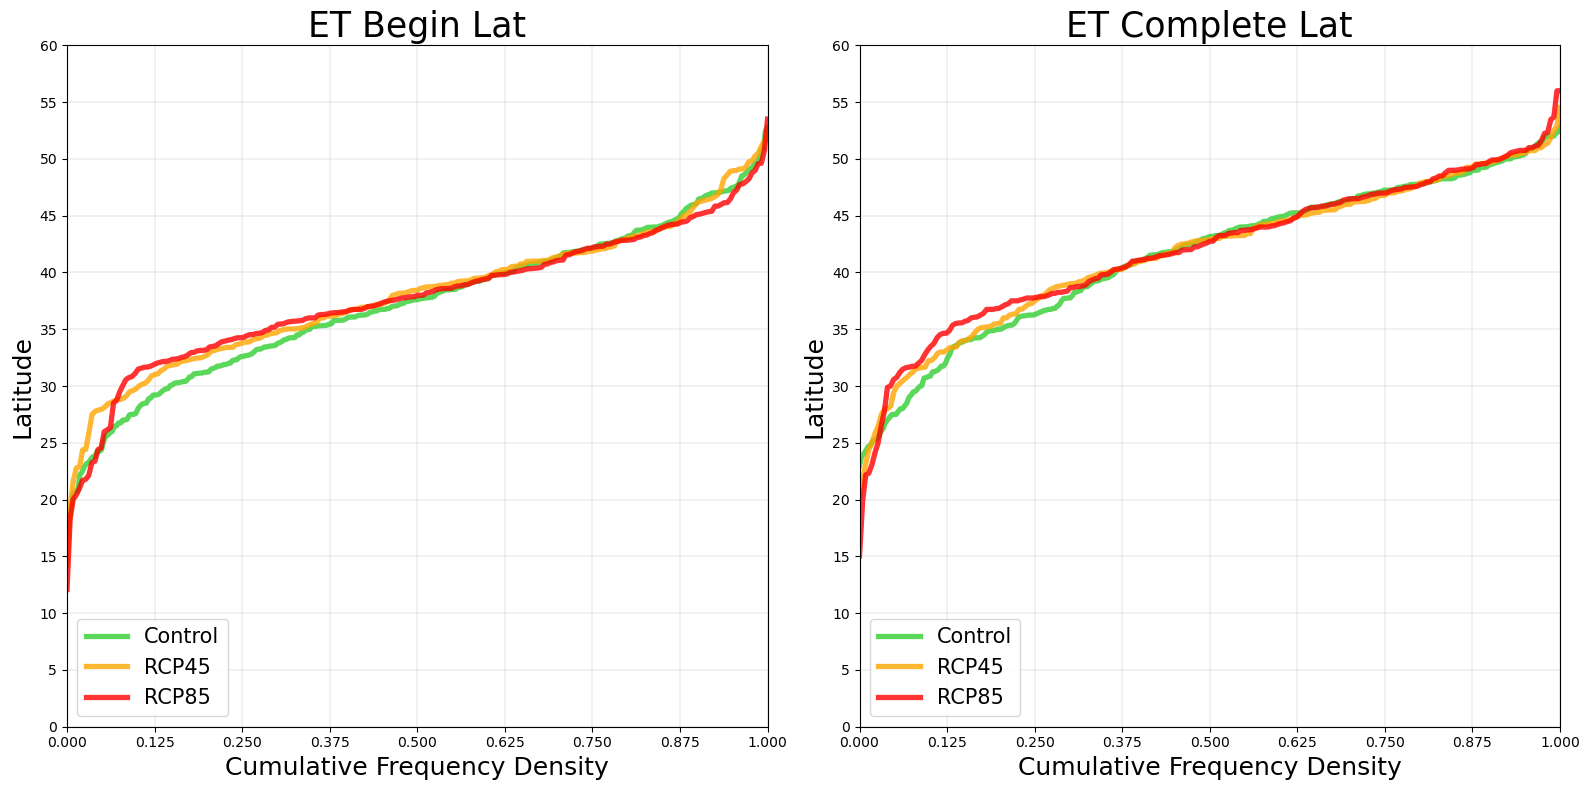

In [15]:
# Latitude
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Begin Lat", True, True, False)
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Complete Lat", False, True, False)
pyplot.tight_layout()
Figname = str('ET_Latitude_Cumulative.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

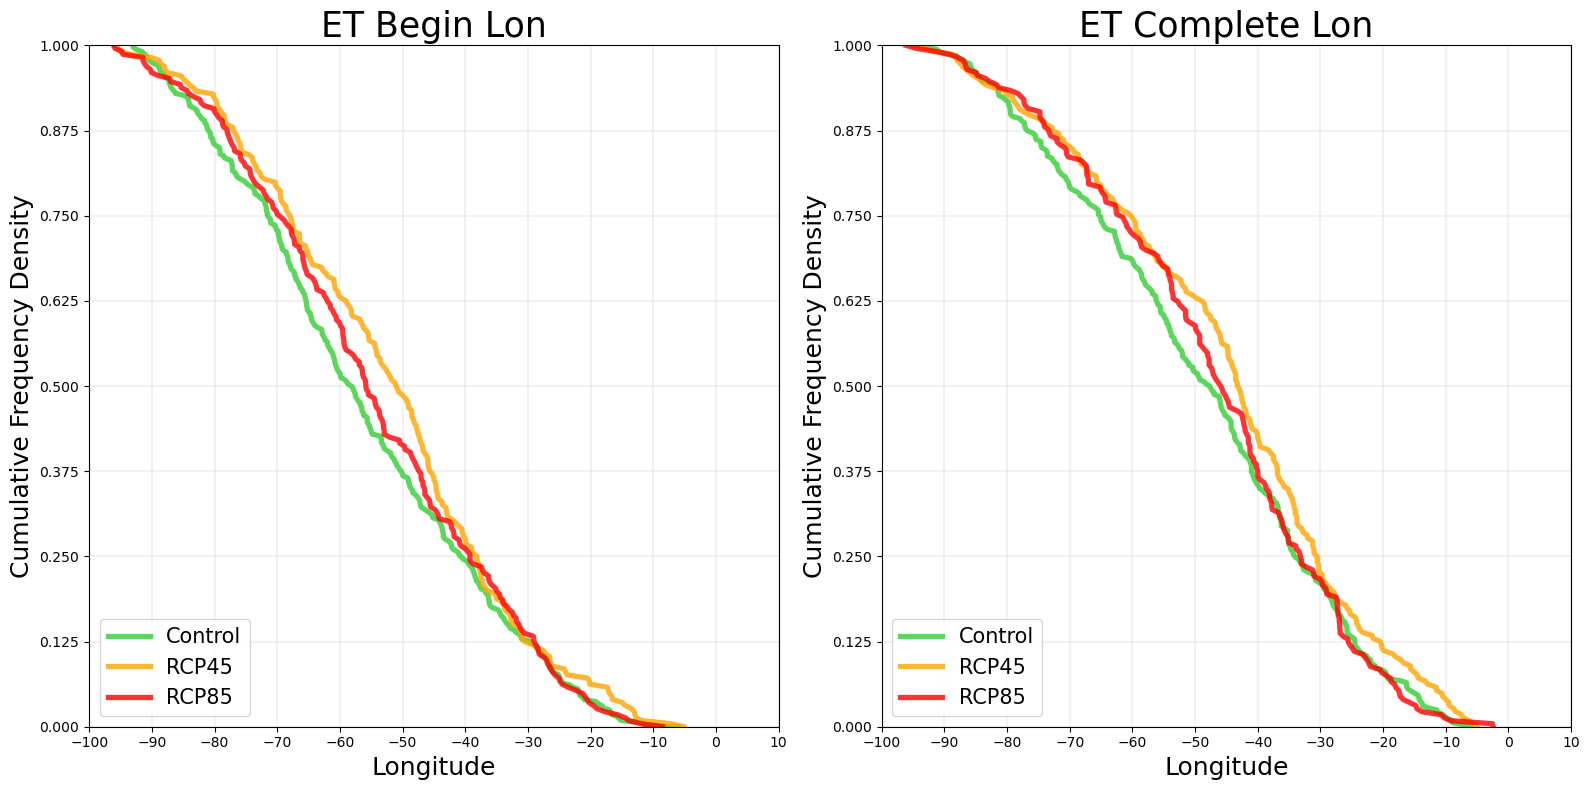

In [16]:
# Longitude
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Begin Lon", True, False, True)
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Complete Lon", False, False, True)
pyplot.tight_layout()
Figname = str('ET_Longitude_Cumulative.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

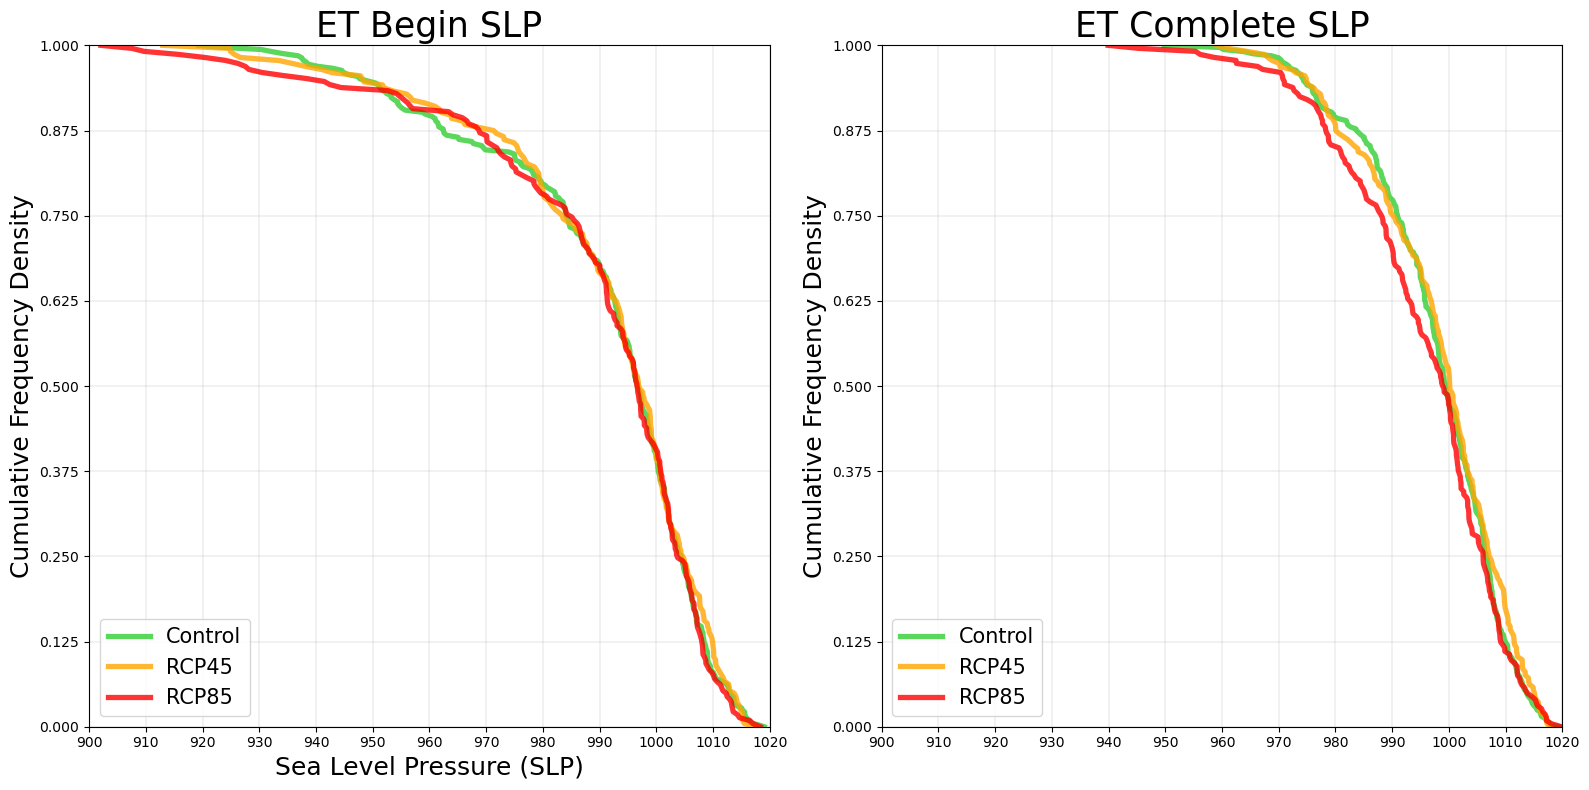

In [17]:
# Sea Level Pressure
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Begin SLP", True, False, True)
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Complete SLP", False, False, True)
pyplot.tight_layout()
Figname = str('ET_SLP_Cumulative.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [18]:
# Function to Plot Probability Distribution Functions
def Prob_Dist(Param, Width, Cum_Sorted, Len, Prob_Vals, Range):
    Prob_Count = numpy.zeros(Range+1)
    for k in range(Range):
        if k == 0:
            Vals_Range = []
        elif k == Len-1:
            Vals_Range = []
        else:
            Vals_Range = Cum_Sorted[(Cum_Sorted >= Prob_Vals[k]-Param) & \
            (Cum_Sorted <= Prob_Vals[k]+Param)]
        Prob_Count[k] = len(Vals_Range) * numpy.abs(Width) / (Param * 2)
    Prob_Dens = Prob_Count / Len
    Prob_Density = Prob_Dens / numpy.sum(Prob_Dens)
    return (Prob_Density)

In [19]:
# Function to Plot Probability Distribution Functions
def Prob_Dist_Combine(DF, Var, Ascend, Width, Params):
# Find Cumulative Distribution
    Cum_Sorted, Cum_Density = Cum_Dist(DF[Var], Ascend)
    Len = len(Cum_Sorted)
#
# Prob Distribution
    Start_Val = (int(Cum_Sorted[0] / Width - (Params[0] + 0.001))) * Width
    End_Val = (int(Cum_Sorted[Len-1] / Width + (Params[0] + 1.001))) * Width
    Range = int((End_Val - Start_Val) / Width)
    Prob_Vals = Create_Bins(Start_Val, End_Val, Width)
    Prob_Density_All = numpy.zeros((len(Params), Range+1))
    for l in range(len(Params)):
        Prob_Density_All[l] = Prob_Dist(Params[l], Width, Cum_Sorted, Len, Prob_Vals, Range)
    Prob_Density_Mean = numpy.mean(Prob_Density_All, axis=0)
    return (Prob_Vals, Prob_Density_Mean)

In [20]:
Kinen = numpy.array([[728,316,320], [518,509,525], [1020,1205,212], [208,830,330]])
numpy.mean(Kinen, axis=0)

array([618.5 , 715.  , 346.75])

In [21]:
# Create Function to Plot ET Cumulative Distributions
def ET_Prob_Dist_Plot(Fig, ET_DF_1, ET_DF_2, ET_DF_3, Var, Begin, Ascend, Horiz, Width, Params):
    if Begin == True:
        Axis = Fig.add_subplot(1,2,1)
    else:
        Axis = Fig.add_subplot(1,2,2)
#    else:
#        Axis = Fig.add_subplot(1,1,1)
#
# Apply Probability Distribution Function For Different Params
    Values_1, Density_1 = Prob_Dist_Combine(ET_DF_1, Var, Ascend, Width, Params)
    Values_2, Density_2 = Prob_Dist_Combine(ET_DF_2, Var, Ascend, Width, Params)
    Values_3, Density_3 = Prob_Dist_Combine(ET_DF_3, Var, Ascend, Width, Params)
#
# Plotting
    if Horiz == True:
        Axis.plot(Values_1, Density_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Values_2, Density_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Values_3, Density_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Density_1, Values_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Density_2, Values_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Density_3, Values_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
#
# Formatting Based on Variable
    ET_Prob_Dist_Formatting(Values_1, Values_2, Values_3, Density_1, Density_2, Density_3, Var, Horiz)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [22]:
# Formatting Based on Variable
def ET_Prob_Dist_Formatting(Vals_1, Vals_2, Vals_3, Dens_1, Dens_2, Dens_3, Var, Horiz):
# x Ticks and Lims
    if Var == "ET Begin Lat" or Var == "ET Complete Lat":
        Min = 0
        Max = 60
        Width = 5
    elif Var == "ET Begin Lon" or Var == "ET Complete Lon":
        Min = -100
        Max = 10
        Width = 10
    elif Var == "ET Begin SLP" or Var == "ET Complete SLP":
        Min = 890
        Max = 1020
        Width = 10
    x_Ticks = Create_Bins(Min, Max, Width)
#
# y Ticks and Lims
    Max_Dens = numpy.max([numpy.max(Dens_1), numpy.max(Dens_2), numpy.max(Dens_3)])
    if Max_Dens <= 0.005:
        y_Width = 0.0005
    elif Max_Dens <= 0.01:
        y_Width = 0.001
    elif Max_Dens <= 0.02:
        y_Width = 0.002
    elif Max_Dens <= 0.05:
        y_Width = 0.005
    elif Max_Dens <= 0.1:
        y_Width = 0.01
    elif Max_Dens <= 0.2:
        y_Width = 0.02
    else:
        y_Width = 0.05
    y_Max = (int(Max_Dens / y_Width) + 1) * y_Width
    y_Ticks = Create_Bins(0, y_Max, y_Width)
    if Horiz == True:
        pyplot.xticks(x_Ticks)
        pyplot.xlim(Min, Max)
        pyplot.yticks(y_Ticks)
        pyplot.ylim(0,y_Max)
    else:
        pyplot.yticks(x_Ticks)
        pyplot.ylim(Min, Max)
        pyplot.xticks(y_Ticks)
        pyplot.xlim(0,y_Max)
#
# Labels and Title
    if Horiz == True:
        pyplot.ylabel("Probability Frequency Density", fontsize=18)
        if Var == "ET Begin Lon" or Var == "ET Complete Lon":
            pyplot.xlabel("Longitude", fontsize=18)
        elif Var == "ET Begin SLP" or Var == "ET  Complete SLP":
            pyplot.xlabel("Sea Level Pressure (SLP)", fontsize=18)
    else:
        pyplot.xlabel("Probability Frequency Density", fontsize=18)
        pyplot.ylabel("Latitude", fontsize=18)
    Title = Var
    pyplot.title(Title, fontsize=25)
#
# Legend
    if Var == "ET Begin Lat" or Var == "ET Complete Lat":
        pyplot.legend(loc=4, fontsize=15)
    else:
        pyplot.legend(loc=2, fontsize=15)

In [23]:
# Plot Probability Density Functions

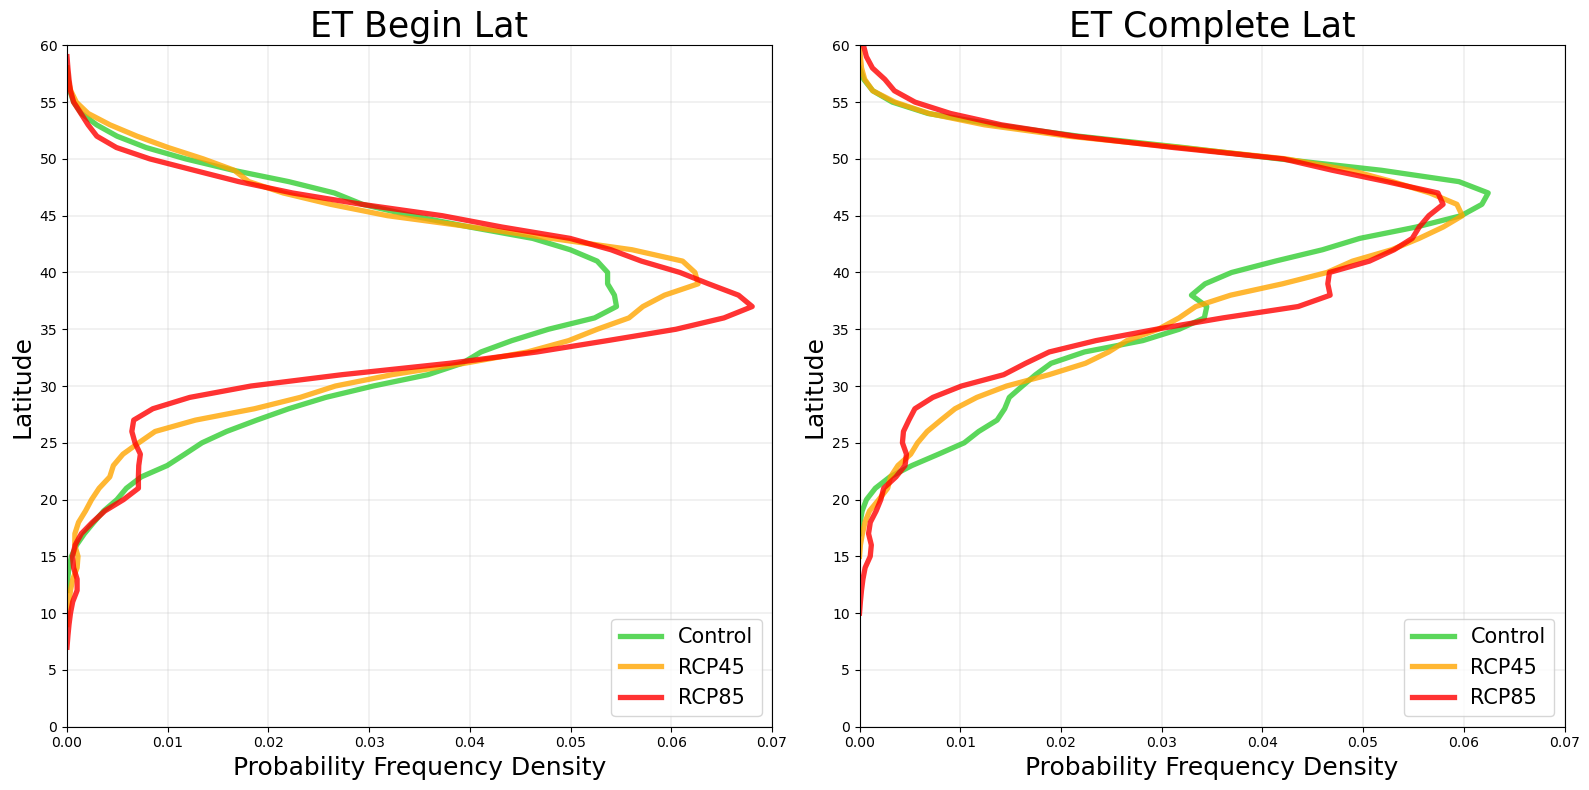

In [24]:
# Latitude
Fig = pyplot.figure(figsize=(16,8))
Params = Create_Bins(5,1,-1)
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Begin Lat", True, True, False, 1, Params)
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Complete Lat", False, True, False, 1, Params)
pyplot.tight_layout()
Figname = str('ET_Latitude_Probability.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

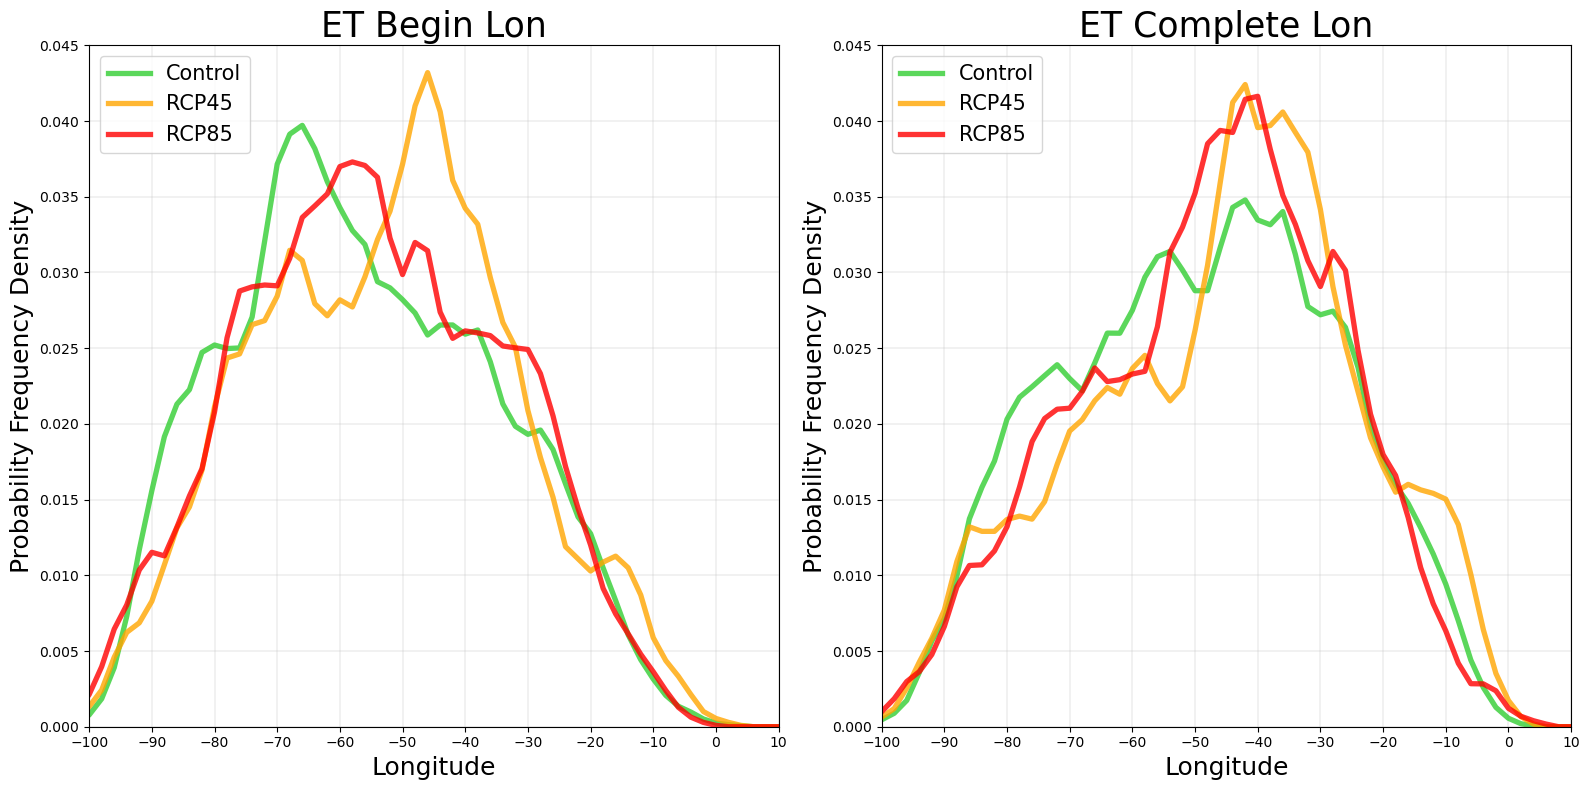

In [25]:
# Longitude
Fig = pyplot.figure(figsize=(16,8))
Params = Create_Bins(10,2,-2)
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Begin Lon", True, False, True, -2, Params)
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Complete Lon", False, False, True, -2, Params)
pyplot.tight_layout()
Figname = str('ET_Longitude_Probability.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

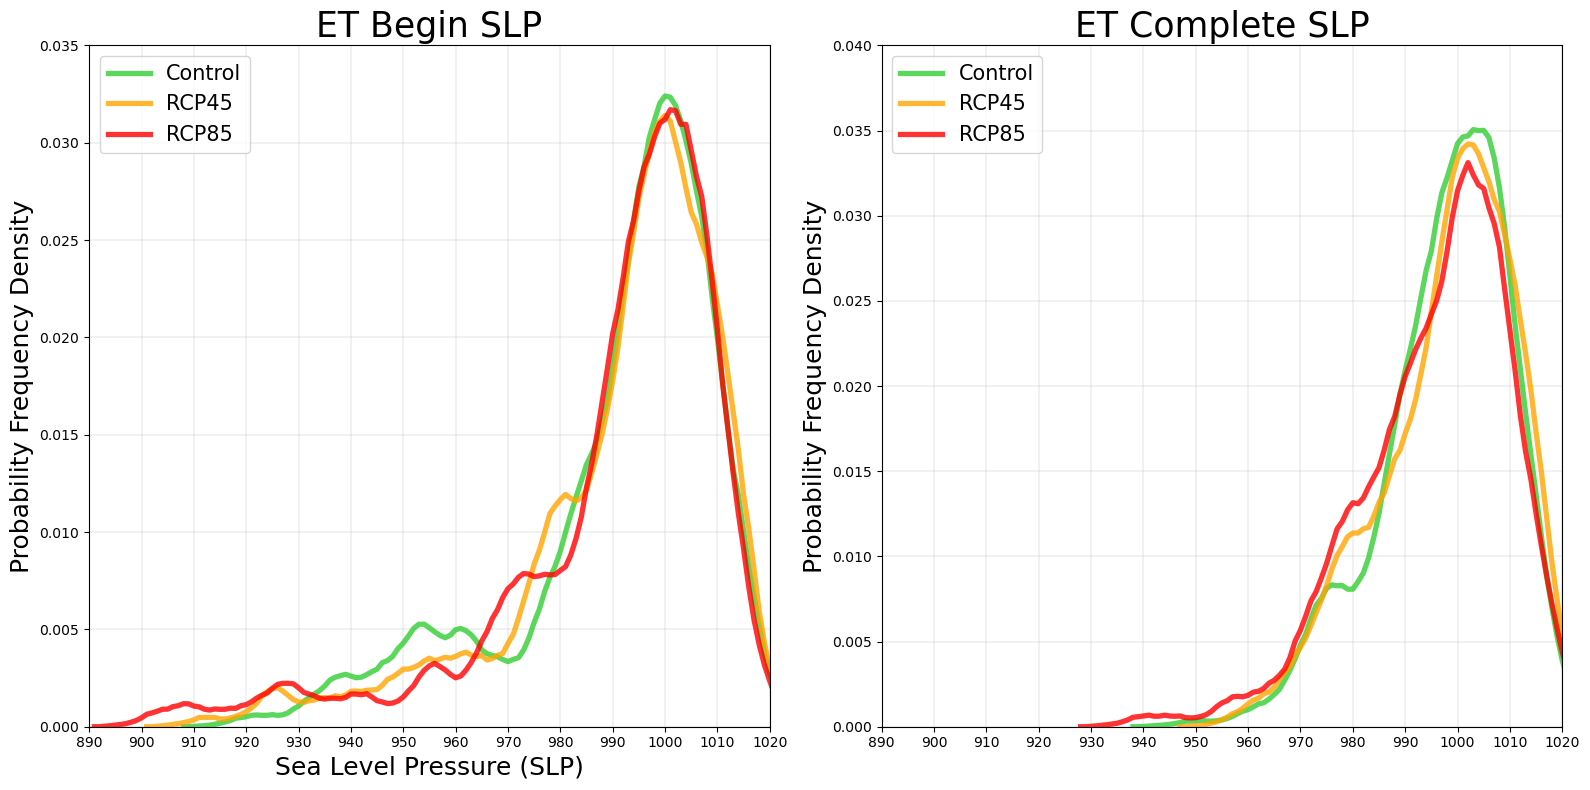

In [26]:
# Longitude
Fig = pyplot.figure(figsize=(16,8))
Params = Create_Bins(10,2,-1)
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Begin SLP", True, False, True, -1, Params)
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Complete SLP", False, False, True, -1, Params)
pyplot.tight_layout()
Figname = str('ET_SLP_Probability.png')
Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [27]:
# Create Function to Plot Phase Space Parameters Cumulative Distributions
def Param_Cum_Dist_Plot(Fig, Data_DF_1, Data_DF_2, Data_DF_3, Var, Begin, Ascend, Horiz):
    if Begin == True:
        Axis = Fig.add_subplot(1,2,1)
    else:
        Axis = Fig.add_subplot(1,2,2)
#
# Apply Cumulative Distribution Function
    Sorted_1, Density_1 = Cum_Dist(Data_DF_1[Var], Ascend)
    Sorted_2, Density_2 = Cum_Dist(Data_DF_2[Var], Ascend)
    Sorted_3, Density_3 = Cum_Dist(Data_DF_3[Var], Ascend)
#
# Plotting
    if Horiz == True:
        Axis.plot(Sorted_1, Density_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Sorted_2, Density_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Sorted_3, Density_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Density_1, Sorted_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Density_2, Sorted_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Density_3, Sorted_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
#
# Formatting Based on Variable
    Param_Cum_Dist_Formatting(Sorted_1, Sorted_2, Sorted_3, Var, Horiz)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [28]:
# Formatting Based on Variable
def Param_Cum_Dist_Formatting(Vals_1, Vals_2, Vals_3, Var, Horiz):
# x Ticks and Lims
    if Var == "B":
        Min = -45
        Max = 135
        Width = 15
    elif Var == "VLT" or Var == "VUT":
        Min = -500
        Max = 500
        Width = 100
    x_Ticks = Create_Bins(Min, Max, Width)
#
# y Ticks and Lims
    if Horiz == True:
        pyplot.xticks(x_Ticks)
        pyplot.xlim(Min, Max)
        pyplot.yticks(Create_Bins(0,1,0.125))
        pyplot.ylim(0,1)
    else:
        pyplot.yticks(x_Ticks)
        pyplot.ylim(Min, Max)
        pyplot.xticks(Create_Bins(0,1,0.125))
        pyplot.xlim(0,1)
#
# Labels and Title
    if Horiz == True:
        pyplot.ylabel("Cumulative Frequency Density", fontsize=18)
        pyplot.xlabel(Var, fontsize=18)
    else:
        pyplot.xlabel("Cumulative Frequency Density", fontsize=18)
        pyplot.ylabel(Var, fontsize=18)
    Title = Var
    pyplot.title(Title, fontsize=25)
#
# Legend
    pyplot.legend(loc=2, fontsize=15)

In [29]:
# Create Function to Plot ET Cumulative Distributions
def Param_Prob_Dist_Plot(Fig, Data_DF_1, Data_DF_2, Data_DF_3, Var, Begin, Ascend, Horiz, Width, Params):
    if Begin == True:
        Axis = Fig.add_subplot(1,2,1)
    else:
        Axis = Fig.add_subplot(1,2,2)
#
# Apply Probability Distribution Function For Different Params
    Values_1, Density_1 = Prob_Dist_Combine(Data_DF_1, Var, Ascend, Width, Params)
    Values_2, Density_2 = Prob_Dist_Combine(Data_DF_2, Var, Ascend, Width, Params)
    Values_3, Density_3 = Prob_Dist_Combine(Data_DF_3, Var, Ascend, Width, Params)
#
# Plotting
    if Horiz == True:
        Axis.plot(Values_1, Density_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Values_2, Density_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Values_3, Density_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Density_1, Values_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Density_2, Values_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Density_3, Values_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
#
# Formatting Based on Variable
    Param_Prob_Dist_Formatting(Values_1, Values_2, Values_3, Density_1, Density_2, Density_3, Var, Horiz)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [30]:
# Formatting Based on Variable
def Param_Prob_Dist_Formatting(Vals_1, Vals_2, Vals_3, Dens_1, Dens_2, Dens_3, Var, Horiz):
# x Ticks and Lims
    if Var == "B":
        Min = -45
        Max = 135
        Width = 15
    elif Var == "VLT" or Var == "VUT":
        Min = -500
        Max = 500
        Width = 100
    x_Ticks = Create_Bins(Min, Max, Width)
#
# y Ticks and Lims
    Max_Dens = numpy.max([numpy.max(Dens_1), numpy.max(Dens_2), numpy.max(Dens_3)])
    if Max_Dens <= 0.0005:
        y_Width = 0.00005
    elif Max_Dens <= 0.001:
        y_Width = 0.0001
    elif Max_Dens <= 0.002:
        y_Width = 0.0002
    elif Max_Dens <= 0.005:
        y_Width = 0.0005
    elif Max_Dens <= 0.01:
        y_Width = 0.001
    elif Max_Dens <= 0.02:
        y_Width = 0.002
    else:
        y_Width = 0.005
    y_Max = (int(Max_Dens / y_Width) + 1) * y_Width
    y_Ticks = Create_Bins(0, y_Max, y_Width)
    if Horiz == True:
        pyplot.xticks(x_Ticks)
        pyplot.xlim(Min, Max)
        pyplot.yticks(y_Ticks)
        pyplot.ylim(0,y_Max)
    else:
        pyplot.yticks(x_Ticks)
        pyplot.ylim(Min, Max)
        pyplot.xticks(y_Ticks)
        pyplot.xlim(0,y_Max)
#
# Labels and Title
    if Horiz == True:
        pyplot.ylabel("Probability Frequency Density", fontsize=18)
        pyplot.xlabel(Var, fontsize=18)
    else:
        pyplot.xlabel("Probability Frequency Density", fontsize=18)
        pyplot.ylabel(Var, fontsize=18)
    Title = Var
    pyplot.title(Title, fontsize=25)
#
# Legend
    pyplot.legend(loc=1, fontsize=15)

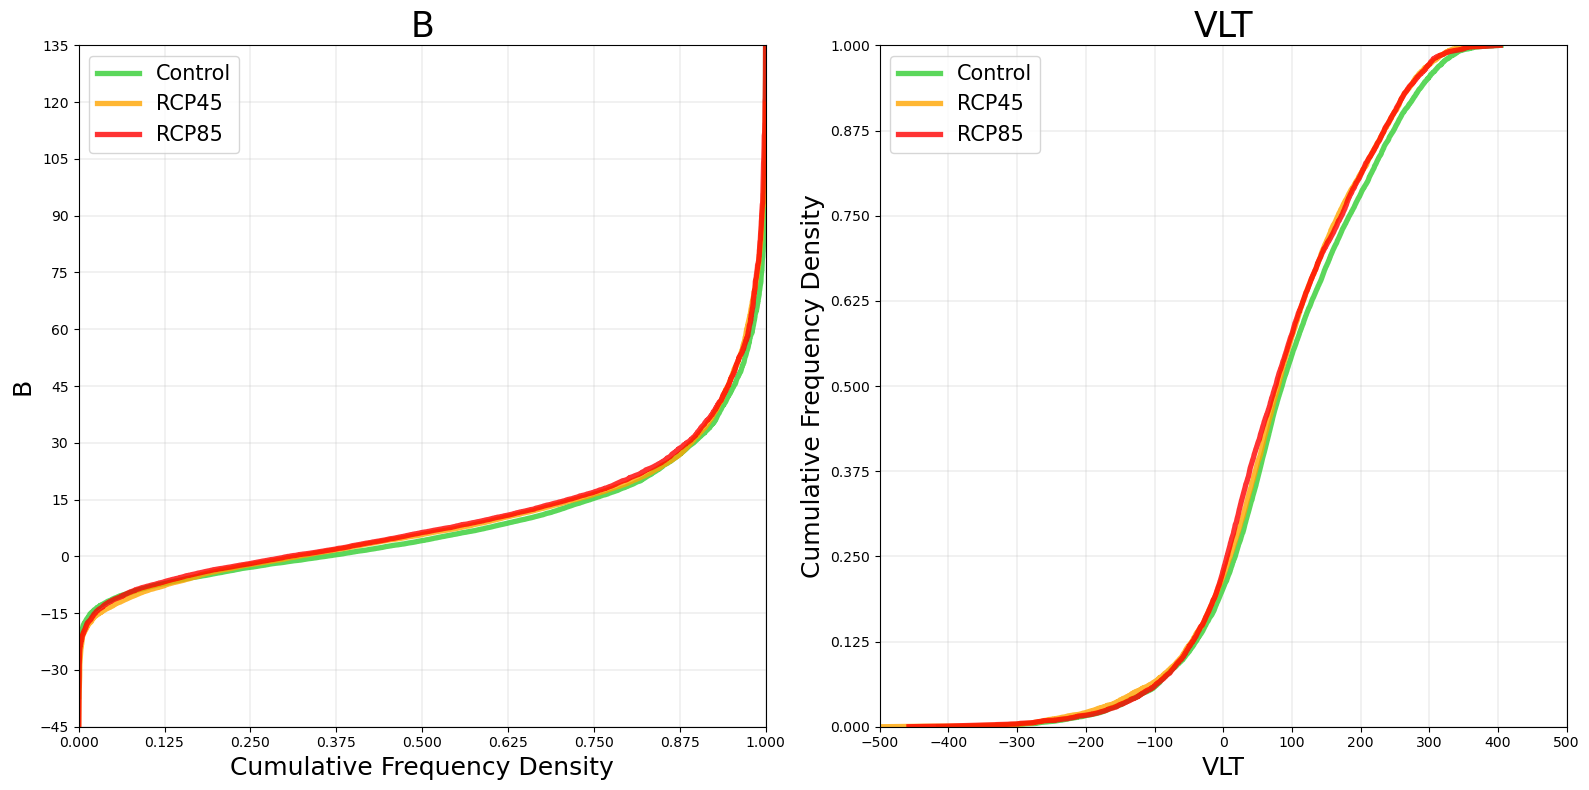

In [31]:
# B and VLT
Fig = pyplot.figure(figsize=(16,8))
Param_Cum_Dist_Plot(Fig, Control_Data, RCP45_Data, RCP85_Data, "B", True, True, False)
Param_Cum_Dist_Plot(Fig, Control_Data, RCP45_Data, RCP85_Data, "VLT", False, True, True)
pyplot.tight_layout()
Figname = str('B_VLT_Cumulative.png')
#Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

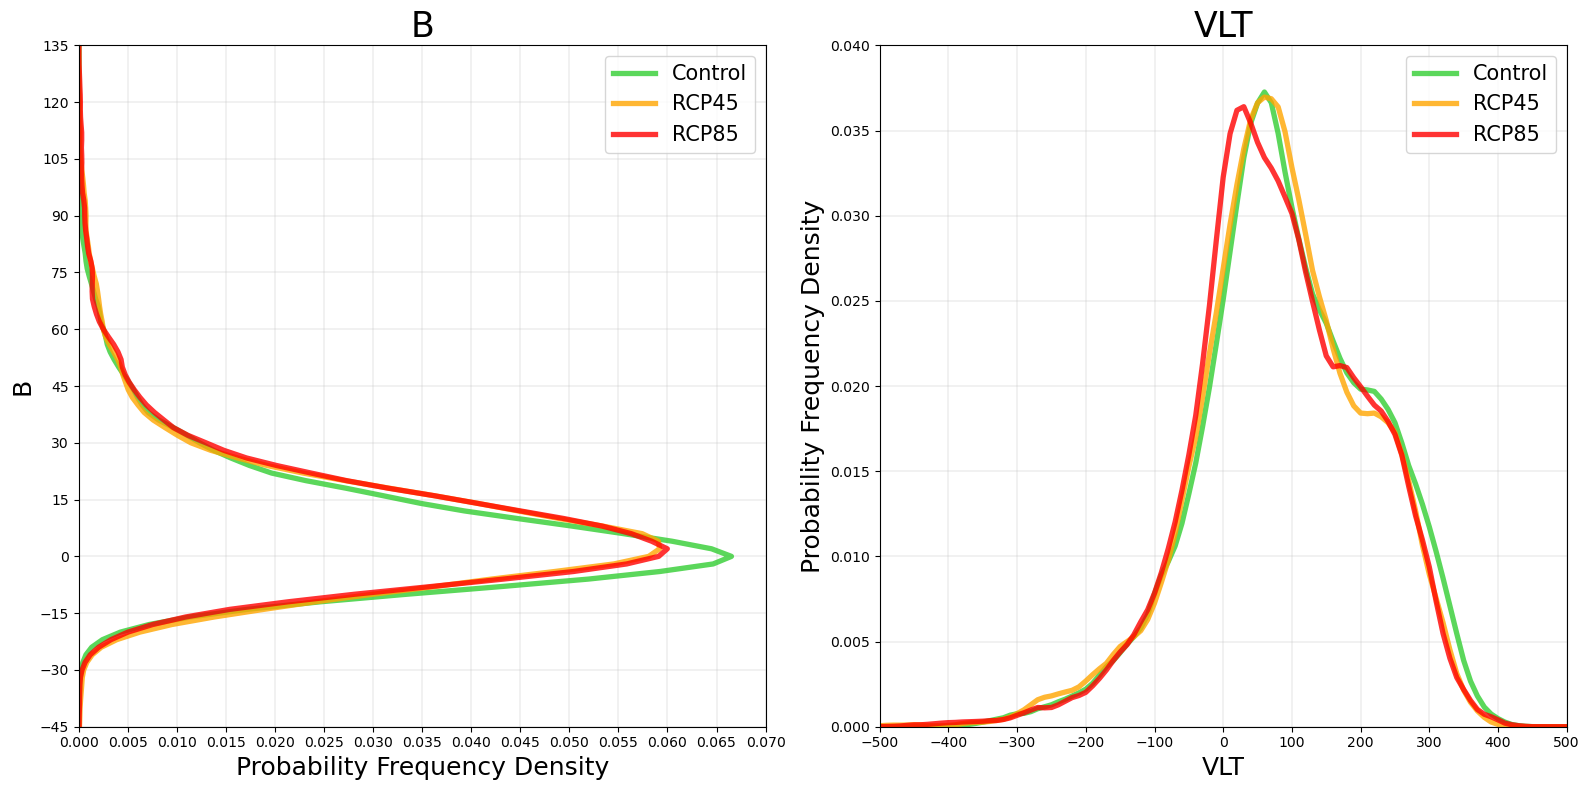

In [32]:
# B and VLT
Fig = pyplot.figure(figsize=(16,8))
Params_B = Create_Bins(10,2,-2)
Params_VLT = Create_Bins(50,10,-10)
Param_Prob_Dist_Plot(Fig, Control_Data, RCP45_Data, RCP85_Data, "B", True, True, False, 2, Params_B)
Param_Prob_Dist_Plot(Fig, Control_Data, RCP45_Data, RCP85_Data, "VLT", False, True, True, 10, Params_VLT)
pyplot.tight_layout()
#Figname = str('B_VLT_Probability.png')
#Fig.savefig(Output_Diri+Figname, bbox_inches='tight')